
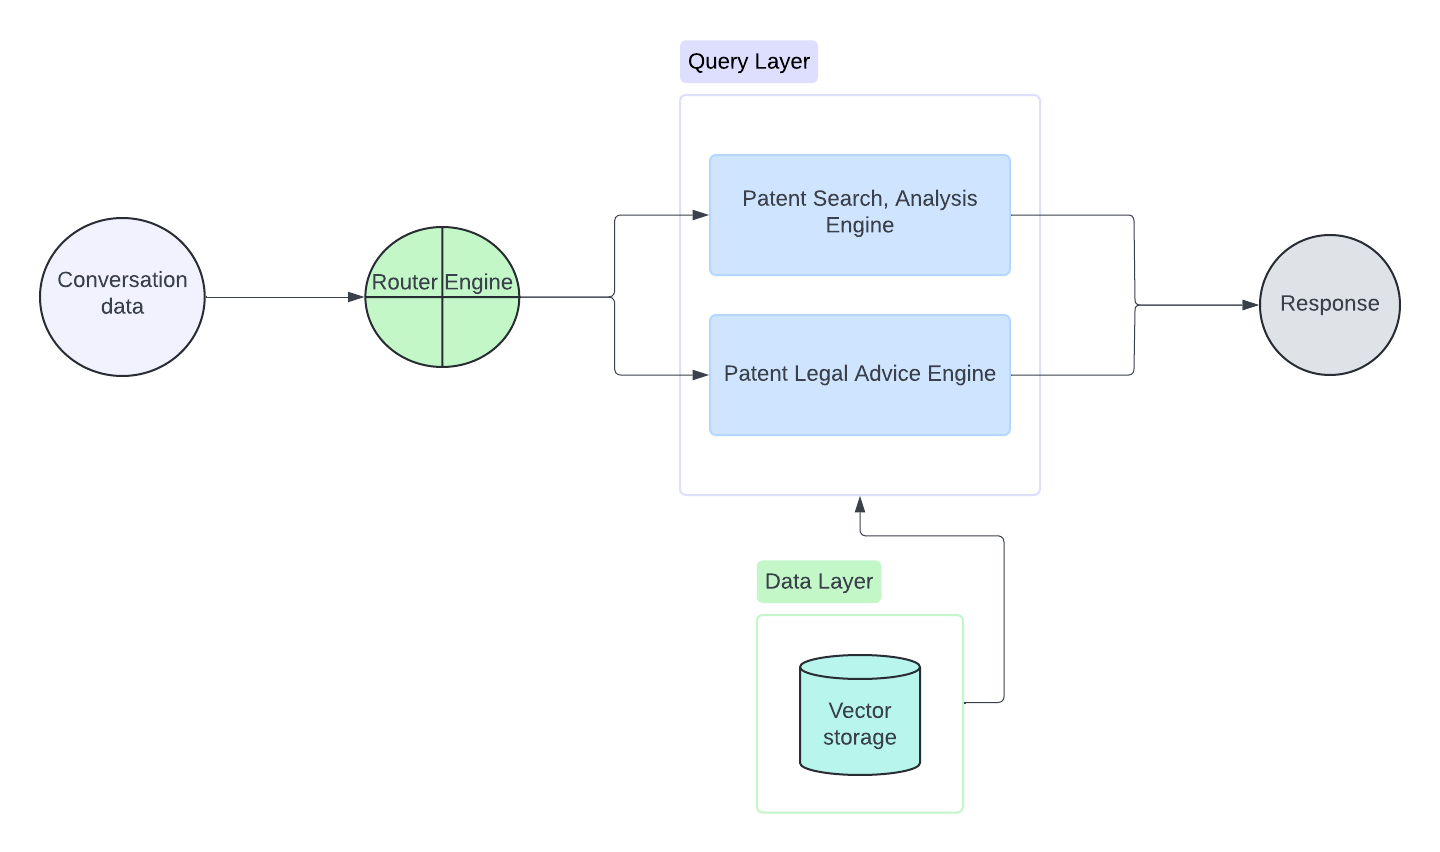

### **Creating the Patent Search, Analysis Engine**





#### **Download modules**

In [ ]:
# Uncomment the below lines if you want to infer pre-computed quantised models
# !pip install bitsandbytes peft trl accelerate datasets transformers
# !pip install -q xformers

In [1]:
!pip install chromadb sentence-transformers
!pip install "unsloth[kaggle] @ git+https://github.com/unslothai/unsloth.git"
!pip install llama-index
!pip install llama-index-llms-huggingface
!pip install llama-index-embeddings-huggingface
!pip install llama-index-vector-stores-chroma
!pip install llama-index-llms-groq
!pip install PyMuPDF
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.8/526.8 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 32.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.9/59.9 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.0/107.0 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 9.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.7/283.7 k

#### **Constants**

In [2]:
PATENT_INPUT_FILE = './drive/MyDrive/data_5000.csv'
CACHE_DIR = './drive/MyDrive/models'

CHROMA_DB_PATH = './drive/MyDrive/chroma'
CHROMA_COLLECTION_NAME = 'patents-brief-5000'

GEMMA_MODEL_ID = 'unsloth/gemma-7b-bnb-4bit'
EMBED_MODEL_ID = 'BAAI/bge-small-en-v1.5'

#### **Building the dataset**

In [ ]:
import pandas as pd

df = pd.read_csv(PATENT_INPUT_FILE)

df['text'] = df.apply(lambda row: f"Patent ID \"{row['id']}\" titled \"{row['title']}\" \n"
                                            f"has a publication date of \"{row['publication_date']}\" \n"
                                            f"The abstract of the patent is {row['abstract']} \n", axis=1)
                                            # f"The description of the patent is {row['description']} \n"
                                            # f"The claim of the patent is {row['claim']}", axis=1)

docs = df['text'].tolist()

ids= [str(x) for x in df['id'].tolist()]

In [ ]:
df.head(5)

,id,title,assignee,inventor_author,priority_date,filing_creation_date,publication_date,grant_date,result_link,representative_figure_link,abstract,description,claim,text
0,US-11741164-B2,"System and method for modeling, fuzzy concept ...",Dennis Alan Van Dusen,Dennis Alan Van Dusen,2012-08-29,2021-06-03,2023-08-29,2023-08-29,https://patents.google.com/patent/US11741164B2/en,https://patentimages.storage.googleapis.com/11...,The invention provides a system and method for...,\nThis application references and is derived f...,\nWhat is claimed is:\n \n1. A computer-implem...,"Patent ID ""US-11741164-B2"" titled ""System and ..."
1,US-11700190-B2,Technologies for annotating process and user i...,"Cisco Technology, Inc.","Navindra Yadav, Abhishek Ranjan Singh, Anubhav...",2015-06-05,2021-10-15,2023-07-11,2023-07-11,https://patents.google.com/patent/US11700190B2/en,https://patentimages.storage.googleapis.com/32...,"Systems, methods, and computer-readable media ...",\nCROSS-REFERENCE TO RELATED APPLICATIONS\nThi...,\nWhat is claimed is:\n \n1. A network traffic...,"Patent ID ""US-11700190-B2"" titled ""Technologie..."
2,US-11322481-B2,Hybrid bonding technology for stacking integra...,"Taiwan Semiconductor Manufacturing Company, Ltd.","Kuo-Ming Wu, Ching-Chun Wang, Dun-Nian Yaung, ...",2018-08-15,2020-06-16,2022-05-03,2022-05-03,https://patents.google.com/patent/US11322481B2/en,https://patentimages.storage.googleapis.com/bc...,A three-dimensional (3D) integrated circuit (I...,\nREFERENCE TO RELATED APPLICATION\nThis Appli...,\nWhat is claimed is:\n \n1. A three-dimension...,"Patent ID ""US-11322481-B2"" titled ""Hybrid bond..."
3,US-11086650-B2,Technologies for application-specific network ...,Intel Corporation,"Stephen T. Palermo, Gerald Rogers, Shih-Wei Ro...",2017-09-01,2018-02-25,2021-08-10,2021-08-10,https://patents.google.com/patent/US11086650B2/en,https://patentimages.storage.googleapis.com/b5...,Technologies for application-specific network ...,\nCROSS-REFERENCE TO RELATED APPLICATION\nThe ...,\nThe invention claimed is:\n \n1. A computing...,"Patent ID ""US-11086650-B2"" titled ""Technologie..."
4,US-2019260781-A1,A cyber security appliance for an operational ...,Darktrace Limited,"Simon Fellows, Jack Stockdale",2018-02-20,2019-02-19,2019-08-22,NaN,https://patents.google.com/patent/US2019026078...,https://patentimages.storage.googleapis.com/31...,A cyber security appliance has one or more mod...,NaN,\nWhat is claimed is:\n \n 1. A cyber security...,"Patent ID ""US-2019260781-A1"" titled ""A cyber s..."


#### **Load/Store documents in vector DB**

In [3]:
from llama_index.core import VectorStoreIndex
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.core import Settings
import chromadb
import torch
from llama_index.vector_stores.chroma import ChromaVectorStore
from llama_index.core import StorageContext
from llama_index.core import Document

Settings.llm = None
device_type = torch.device("cuda" if torch.cuda.is_available() else "cpu")

embed_model = HuggingFaceEmbedding(model_name=EMBED_MODEL_ID, cache_folder=CACHE_DIR, device=device_type)

chroma_client = chromadb.PersistentClient(path=CHROMA_DB_PATH)
chroma_collection = chroma_client.get_or_create_collection(CHROMA_COLLECTION_NAME)

vector_store = ChromaVectorStore(chroma_collection=chroma_collection)
storage_context = StorageContext.from_defaults(vector_store=vector_store)

patent_index = None

if chroma_collection.count() > 0:
    # If documents exist, use the existing vector store
    patent_index = VectorStoreIndex.from_vector_store(vector_store, storage_context=storage_context, embed_model=embed_model)
else:
    # If no documents exist, create the index and store the documents
    patent_documents = [Document(text=text, doc_id=id) for text, id in list(zip(df['text'], df['id']))]
    index = VectorStoreIndex.from_documents(
        patent_documents, storage_context=storage_context, embed_model=embed_model, show_progress=True
    )

    # Reload the vector store
    storage_context = StorageContext.from_defaults(vector_store=vector_store)
    patent_index = VectorStoreIndex.from_vector_store(vector_store, storage_context=storage_context, embed_model=embed_model)

# patent_index is now ready to use

LLM is explicitly disabled. Using MockLLM.


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


#### **Load the LLM**

In [ ]:
from unsloth import FastLanguageModel
import torch
from llama_index.llms.huggingface import HuggingFaceLLM

max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/mistral-7b-bnb-4bit",
    "unsloth/mistral-7b-instruct-v0.2-bnb-4bit",
    "unsloth/llama-2-7b-bnb-4bit",
    "unsloth/gemma-7b-bnb-4bit",
    "unsloth/gemma-7b-it-bnb-4bit", # Instruct version of Gemma 7b
    "unsloth/gemma-2b-bnb-4bit",
    "unsloth/gemma-2b-it-bnb-4bit", # Instruct version of Gemma 2b
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/gemma-7b-bnb-4bit", # Choose ANY! eg teknium/OpenHermes-2.5-Mistral-7B
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

llm_model = HuggingFaceLLM(model=model, tokenizer=tokenizer, context_window=4096, max_new_tokens=max_seq_length)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


/usr/local/lib/python3.10/dist-packages/pydantic/_internal/_fields.py:160: UserWarning: Field "model_id" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


config.json:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

==((====))==  Unsloth: Fast Gemma patching release 2024.6
   \\   /|    GPU: NVIDIA L4. Max memory: 22.168 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.3.0+cu121. CUDA = 8.9. CUDA Toolkit = 12.1.
\        /    Bfloat16 = TRUE. Xformers = 0.0.26.post1. FA = False.
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


model.safetensors:   0%|          | 0.00/5.57G [00:00<?, ?B/s]

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/40.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

#### **Prompt Engineering**

In [4]:
patent_query_engine = patent_index.as_query_engine(
    similarity_top_k=5,
)

In [5]:
prompts_dict = patent_query_engine.get_prompts()
print(list(prompts_dict.keys()))

print(prompts_dict['response_synthesizer:text_qa_template'].conditionals[0][1].message_templates[0].content)
print('----------------------------------------------')
print(prompts_dict['response_synthesizer:text_qa_template'].conditionals[0][1].message_templates[1].content)


['response_synthesizer:text_qa_template', 'response_synthesizer:refine_template']
You are an expert Q&A system that is trusted around the world.
Always answer the query using the provided context information, and not prior knowledge.
Some rules to follow:
1. Never directly reference the given context in your answer.
2. Avoid statements like 'Based on the context, ...' or 'The context information ...' or anything along those lines.
----------------------------------------------
Context information is below.
---------------------
{context_str}
---------------------
Given the context information and not prior knowledge, answer the query.
Query: {query_str}
Answer: 


In [6]:
from llama_index.core import ChatPromptTemplate, PromptTemplate
from llama_index.core.llms import ChatMessage, MessageRole

system_prompt = """
You are an expert assistant specializing in patents.
Your task involves processing a collection of patent abstracts. Perform the following:

1. Provide a coherent and comprehensive summary of these abstracts tailored to the user's specific query.
2. Identify and summarize the key themes, methodologies, and implications of the patents, highlighting any significant innovations.
"""

user_prompt = """
Context information is below.
---------------------
{context_str}
---------------------
Given the context information and not prior knowledge, answer the query.
Query: {query_str}
Answer:
"""

message_template = [
    ChatMessage(content=system_prompt, role=MessageRole.SYSTEM),
    ChatMessage(content=user_prompt, role=MessageRole.USER)
]
prompt_template = ChatPromptTemplate(message_templates=message_template)

In [7]:
patent_query_engine = patent_index.as_query_engine(
    similarity_top_k=3
)


patent_query_engine.update_prompts(
    {"response_synthesizer:text_qa_template": prompt_template}
)

#### **Query the LLM using RAG**

In [ ]:
from IPython.display import Markdown
Markdown(patent_query_engine.query("What are some patents related to deep learning?").response)

1. Patent ID "US-11734006-B2" titled "Deep vision processor " 
2. Patent ID "US-11663456-B2" titled "On-the-fly deep learning in machine learning at autonomous machines " 
3. Patent ID "US-11074495-B2" titled "System and method for extremely efficient image and pattern recognition and artificial intelligence platform " 


In [ ]:
Markdown(patent_query_engine.query("Can you give details about Patent ID US-11734006-B2 titled Deep vision processor ").response)

The abstract of the patent is Disclosed herein is a processor for deep learning. In one embodiment, the processor comprises: a load and store unit configured to load and store image pixel data and stencil data; inconceivably Abbé a register unit, implementing a banked register file, configured to: load and store a subset of the image pixel data from the load and store unit, and concurrently provide access to image pixel values stored in a register file entry of the banked register file, wherein the subset of the image pixel data comprises the image pixel values stored in the register file entry; and a plurality of arithmetic logic units configured to concurrently perform one or more operations on the image pixel values stored in the register file entry and corresponding stencil data of the stencil data.


#### **Using Groq**

In [8]:
from llama_index.llms.groq import Groq
from llama_index.core import Settings
from google.colab import userdata

groq_token = userdata.get('GROQ_TOKEN')

groq_llm = Groq("llama3-8b-8192", api_key=groq_token)
llm = groq_llm
Settings.llm = groq_llm

In [9]:
groq_patent_query_engine = patent_index.as_query_engine(
    llm=groq_llm,
    similarity_top_k=10,
)

In [44]:
from llama_index.core import ChatPromptTemplate, PromptTemplate
from llama_index.core.llms import ChatMessage, MessageRole

groq_system_prompt = """
You are an expert assistant specializing in patents.
Your task involves processing a collection of patent abstracts. Perform the following:

1. Provide a comprehensive summary of these abstracts tailored to the user's specific query.
2. Identify and summarize the key themes, methodologies, and implications of the patents, highlighting any significant innovations.
"""

groq_user_prompt = """
Context information is below.
---------------------
{context_str}
---------------------
Given the context information and not prior knowledge, answer the query.
Query: {query_str}
Answer:
"""

groq_message_template = [
    ChatMessage(content=groq_system_prompt, role=MessageRole.SYSTEM),
    ChatMessage(content=groq_user_prompt, role=MessageRole.USER)
]
final_template = ChatPromptTemplate(message_templates=groq_message_template)

In [11]:
prompts_dict = groq_patent_query_engine.get_prompts()

In [12]:
print(prompts_dict)

{'response_synthesizer:text_qa_template': SelectorPromptTemplate(metadata={'prompt_type': <PromptType.QUESTION_ANSWER: 'text_qa'>}, template_vars=['context_str', 'query_str'], kwargs={}, output_parser=None, template_var_mappings={}, function_mappings={}, default_template=PromptTemplate(metadata={'prompt_type': <PromptType.QUESTION_ANSWER: 'text_qa'>}, template_vars=['context_str', 'query_str'], kwargs={}, output_parser=None, template_var_mappings=None, function_mappings=None, template='Context information is below.\n---------------------\n{context_str}\n---------------------\nGiven the context information and not prior knowledge, answer the query.\nQuery: {query_str}\nAnswer: '), conditionals=[(<function is_chat_model at 0x78d57c75cf70>, ChatPromptTemplate(metadata={'prompt_type': <PromptType.CUSTOM: 'custom'>}, template_vars=['context_str', 'query_str'], kwargs={}, output_parser=None, template_var_mappings=None, function_mappings=None, message_templates=[ChatMessage(role=<MessageRole.

In [45]:
groq_patent_query_engine.update_prompts(
    {"response_synthesizer:text_qa_template": final_template}
)

In [46]:
from IPython.display import Markdown

Markdown(groq_patent_query_engine.query("Give few patents related to big data?").response)

Based on the provided patent abstracts, I can identify the following patents related to big data:

1. Patent ID "US-11468098-B2" titled "Knowledge-intensive data processing system" (published on 2022-10-11) - This patent discusses a system for managing and processing large amounts of complex and high-velocity data using big data and related technologies.
2. Patent ID "US-11669540-B2" titled "Matching subsets of tabular data arrangements to subsets of graphical data arrangements at ingestion into data-driven collaborative datasets" (published on 2023-06-06) - This patent relates to identifying and matching equivalent subsets of data between an ingested dataset (tabular data arrangement) and one or more graph-based data arrangements.

These patents are related to big data as they involve processing large amounts of complex and high-velocity data, using big data technologies, and matching subsets of data between different data arrangements.

Note that Patent ID "US-11366824-B2" titled "Dataset analysis and dataset attribute inferencing to form collaborative datasets" (published on 2022-06-21) is related to data science and data analysis, but it does not specifically focus on big data.

In [15]:
Markdown(groq_patent_query_engine.query("Can you give details about Patent ID US-11734006-B2 titled Deep vision processor").response)

Based on the provided patent abstracts, I can provide a summary and key details about Patent ID US-11734006-B2 titled "Deep vision processor".

**Summary:** The patent describes a processor for deep learning, specifically designed for processing image pixel data and stencil data. The processor comprises a load and store unit, a register unit, and a plurality of arithmetic logic units. The processor is designed to concurrently perform operations on image pixel values and stencil data, enabling efficient processing of deep learning tasks.

**Key details:**

1. **Processor architecture:** The processor consists of a load and store unit, a register unit, and a plurality of arithmetic logic units.
2. **Image pixel data processing:** The processor is designed to process image pixel data, which is loaded and stored in the register unit.
3. **Stencil data processing:** The processor also processes stencil data, which is used in conjunction with the image pixel data to perform deep learning tasks.
4. **Concurrent processing:** The processor is designed to concurrently perform operations on image pixel values and stencil data, enabling efficient processing of deep learning tasks.
5. **Deep learning applications:** The processor is intended for use in deep learning applications, such as image recognition, object detection, and scene understanding.

Overall, Patent ID US-11734006-B2 describes a novel processor architecture designed specifically for deep learning tasks, enabling efficient processing of image and stencil data.

In [ ]:
Markdown(groq_patent_query_engine.query("Can you give details about Patent US-11663456-B2 titled On-the-fly deep learning in machine learning at autonomous machines").response)

Based on the provided patent abstracts, I'll provide a summary of Patent US-11663456-B2 titled "On-the-fly deep learning in machine learning at autonomous machines".

Patent US-11663456-B2 describes a mechanism for facilitating the transfer of features learned by a context-independent pre-trained deep neural network (DNN) to a context-dependent neural network. The mechanism involves extracting a feature learned by a first DNN model, which is a pre-trained DNN model for computer vision to enable context-independent classification of an object within an input video frame. The extracted feature is then used to train a second DNN model for computer vision based on the extracted feature, which is an update of the first DNN model. The training of the second DNN model includes training the second DNN model based on a dataset including context-dependent data.

In essence, this patent focuses on developing a mechanism for adapting pre-trained deep neural networks to context-dependent scenarios, enabling autonomous machines to learn and adapt to new situations on-the-fly. This technology has significant implications for various applications, including autonomous vehicles, robotics, and computer vision.

Key themes and methodologies mentioned in this patent include:

1. Transfer learning: The patent highlights the importance of transferring knowledge learned from a pre-trained model to a new context-dependent scenario.
2. Context-dependent learning: The patent focuses on developing a mechanism for adapting pre-trained models to context-dependent scenarios, enabling autonomous machines to learn and adapt to new situations.
3. Deep learning: The patent leverages deep learning techniques to enable autonomous machines to learn and adapt to new situations.
4. Computer vision: The patent applies computer vision techniques to enable autonomous machines to classify objects within input video frames.

The implications of this patent are significant, as it enables autonomous machines to learn and adapt to new situations on-the-fly, potentially leading to improved performance and decision-making capabilities in various applications.

In [ ]:
Markdown(groq_patent_query_engine.query("Can you give me details on Patent US-11731725-B2 titled Electric vehicle").response)

Based on the provided patent abstracts, I'll provide a summary of Patent US-11731725-B2 titled "Electric vehicle".

Patent US-11731725-B2 is an electric self-balancing vehicle that includes a top cover, bottom cover, inner cover, rotating mechanism, two wheels, two hub motors, a plurality of sensors, a power supply, and a controller. The top cover has a first top cover and a second top cover disposed symmetrically and rotatable relative to each other. The bottom cover is fixed to the top cover and includes a first bottom cover and a second bottom cover disposed symmetrically and rotatable relative to each other. The inner cover is fixed between the top cover and the bottom cover and includes a first inner cover and a second inner cover disposed symmetrically and rotatable relative to each other.

The rotating mechanism is fixed between the first inner cover and the second inner cover. The two wheels are rotatably fixed at two sides of the inner cover, respectively. The two hub motors are fixed in the two wheels, respectively. The plurality of sensors is disposed between the bottom cover and the inner cover, respectively. The power supply is fixed between the first bottom cover and the first inner cover. The controller is fixed between the second bottom cover and the second inner cover, and it is electrically connected with the plurality of sensors, the power supply, and the hub motors. The controller controls the hub motors to drive the corresponding wheels to rotate according to sensing signals transmitted by the sensors.

In summary, this patent describes an electric self-balancing vehicle with a unique design featuring rotatable top and bottom covers, inner cover, and rotating mechanism. The vehicle is equipped with sensors, power supply, and a controller that controls the hub motors to drive the wheels.

#### **Adding a reranker**

In [47]:
from llama_index.core.postprocessor import SentenceTransformerRerank

rerank_postprocessor = SentenceTransformerRerank(
    model='mixedbread-ai/mxbai-rerank-xsmall-v1',
    top_n=3,
    keep_retrieval_score=True
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [48]:
groq_patent_query_engine = patent_index.as_query_engine(
    similarity_top_k=10,
    llm=groq_llm,
    node_postprocessors=[rerank_postprocessor],
)

In [49]:
Markdown(groq_patent_query_engine.query("Present details about some patents related to automobiles").response)

Patents related to automobiles include "Electronic display systems connected to vehicles and vehicle-based systems" (US-10838676-B2 and US-10805659-B2) and "Vehicle diagnostic systems and methods" (US-11188191-B2). These patents describe systems for identifying vehicle locations, driving routes, and driver characteristics, as well as determining customized digital content for electronic roadside displays and vehicle-based devices. Additionally, the patents discuss interactive systems for user responses and follow-up content, and a system for diagnosing and repairing vehicles.

In [50]:
Markdown(groq_patent_query_engine.query("Can you give me details on Patent US-11731725-B2 titled Electric vehicle").response)

The electric self-balancing vehicle described in Patent US-11731725-B2 includes a top cover, a bottom cover, an inner cover, a rotating mechanism, two wheels, two hub motors, a plurality of sensors, a power supply, and a controller. The top cover has a first and second top cover disposed symmetrically and rotatable relative to each other. The bottom cover is fixed to the top cover and includes a first and second bottom cover disposed symmetrically and rotatable relative to each other. The inner cover is fixed between the top cover and the bottom cover and includes a first and second inner cover disposed symmetrically and rotatable relative to each other. The rotating mechanism is fixed between the first inner cover and the second inner cover. The two wheels are rotatably fixed at two sides of the inner cover, respectively. The two hub motors are fixed in the two wheels, respectively. The plurality of sensors is disposed between the bottom cover and the inner cover, respectively. The power supply is fixed between the first bottom cover and the first inner cover. The controller is fixed between the second bottom cover and the second inner cover, and is electrically connected with the plurality of sensors, the power supply, and the hub motors, and controls the hub motors to drive the corresponding wheels to rotate according to sensing signals transmitted by the sensors.

In [51]:
new_query = "I have developed a system for diagnosing and repairing vehicles which includes a vehicle interface that transmits instructions to an adaptor connected to a vehicle and retrieves diagnostic trouble codes from the adaptor. Are there any existing patents similar to this invention? If so can you please present explain such patents and also when they were published."
Markdown(groq_patent_query_engine.query(new_query).response)

Yes, there are existing patents similar to your invention. Two patents that come close to your description are:

Patent ID "US-11188191-B2" titled "Vehicle diagnostic systems and methods" published on "2021-11-30". This patent describes a system for diagnosing and repairing vehicles, which includes a vehicle interface that transmits instructions to an adaptor connected to a vehicle and retrieves diagnostic trouble codes from the adaptor.

Patent ID "US-11232655-B2" titled "System and method for interfacing with a vehicular controller area network" published on "2022-01-25". This patent describes a vehicle monitoring system that includes an interface configured to at least communicate with a controller area network bus, which is similar to your vehicle interface that transmits instructions to an adaptor connected to a vehicle.

Both of these patents are related to vehicle diagnostic systems and methods, and they were published in 2021 and 2022, respectively.

### **Creating the Legal Advice Engine**

#### **Constants**

In [21]:
RULEBOOK_FILE = './drive/MyDrive/consolidated_laws.pdf'
RULEBOOK_CHROMA_COLLECTION = 'patents-rulebook'

#### **Building the dataset**

In [22]:
import fitz

rulebook_documents = []

In [ ]:
def read_pdf(file_path):
    document = fitz.open(file_path)
    for page_num in range(len(document)):
        page = document.load_page(page_num)
        text = page.get_text("text")
        rulebook_documents.append(Document(text=text, doc_id=page_num))

read_pdf(RULEBOOK_FILE)

#### **Creating the index**

In [23]:
chroma_client = chromadb.PersistentClient(path=CHROMA_DB_PATH)
rulebook_chroma_collection = chroma_client.get_or_create_collection(RULEBOOK_CHROMA_COLLECTION)

rulebook_vector_store = ChromaVectorStore(chroma_collection=rulebook_chroma_collection)
rulebook_storage_context = StorageContext.from_defaults(vector_store=rulebook_vector_store)

rulebook_index = None

if rulebook_chroma_collection.count() > 0:
    # If documents exist, use the existing vector store
    rulebook_index = VectorStoreIndex.from_vector_store(rulebook_vector_store, storage_context=rulebook_storage_context, embed_model=embed_model)
else:
    # If no documents exist, create the index and store the documents
    index = VectorStoreIndex.from_documents(
        rulebook_documents, storage_context=rulebook_storage_context, embed_model=embed_model, show_progress=True
    )

    # Reload the vector store
    storage_context = StorageContext.from_defaults(vector_store=rulebook_vector_store)
    rulebook_index = VectorStoreIndex.from_vector_store(rulebook_vector_store, storage_context=rulebook_storage_context, embed_model=embed_model)

# patent_index is now ready to use

#### **Preparing the engine**

In [52]:
rulebook_query_engine = rulebook_index.as_query_engine(
    llm=groq_llm,
    similarity_top_k=10,
    node_postprocessors=[rerank_postprocessor]
)

In [53]:
rulebook_system_prompt = """
You are an expert assistant specializing in patent laws, rules and produdures.
Your task involves processing a collection of patent abstracts. Perform the following:

1. Provide a coherent and comprehensive summary of these rules/laws/procedures tailored to the user's specific query.
2. Identify and summarize the key themes, and implications of these patent laws/rules.
"""

rulebook_user_prompt = """
Context information is below.
---------------------
{context_str}
---------------------
Given the context information and not prior knowledge, answer the query.
Query: {query_str}
Answer:
"""

rulebook_message_template = [
    ChatMessage(content=rulebook_system_prompt, role=MessageRole.SYSTEM),
    ChatMessage(content=rulebook_user_prompt, role=MessageRole.USER)
]
rulebook_prompt = ChatPromptTemplate(message_templates=rulebook_message_template)

In [54]:
rulebook_query_engine.update_prompts(
    {"response_synthesizer:text_qa_template": rulebook_prompt}
)

In [55]:
Markdown(rulebook_query_engine.query("What are the steps to file a patent? Explain in detail.").response)

Based on the provided patent laws and procedures, I will outline the steps to file a patent. Please note that these steps are specific to the United States Patent and Trademark Office (USPTO) and may vary depending on the jurisdiction.

**Step 1: Determine Patentability**

Before filing a patent application, it is essential to determine whether your invention is patentable. You can do this by conducting a patent search to identify existing patents and publications that may be relevant to your invention.

**Step 2: Prepare a Patent Application**

Once you have determined that your invention is patentable, you can prepare a patent application. A patent application typically includes:

1. A detailed description of your invention, including drawings and diagrams.
2. A set of claims that define the scope of your invention.
3. An abstract that summarizes your invention.

**Step 3: File a Patent Application**

You can file your patent application with the USPTO. You can file online or by mail. The application fee for a utility patent is currently $65 for small entities and $1,600 for large entities.

**Step 4: Wait for Patent Office Review**

After filing your application, the USPTO will review your invention to determine whether it meets the requirements for a patent. This process can take several months to several years.

**Step 5: Respond to Office Actions**

If the USPTO identifies any issues with your application, you will receive an office action. You will need to respond to the office action by addressing the issues raised and providing any additional information or amendments to your application.

**Step 6: Receive a Patent**

If your application is approved, you will receive a patent. A patent is a legal right granted to the inventor that gives them the exclusive right to make, use, and sell their invention for a certain period of time.

**Additional Steps**

In addition to the above steps, there are some additional steps you may need to take:

1. **Request for Reexamination**: If you believe that a patent is invalid or that a new invention is substantially similar to an existing patent, you can request a reexamination of the patent.
2. **Patent Reexamination**: If a reexamination is granted, the USPTO will review the patent to determine whether it is still valid.
3. **Appeals**: If you disagree with a decision made by the USPTO, you can appeal the decision to the Patent Trial and Appeal Board.

In conclusion, the steps to file a patent involve preparing a patent application, filing it with the USPTO, waiting for review, responding to office actions, and receiving a patent. Additionally, there are some additional steps you may need to take, such as requesting a reexamination or appealing a decision made by the USPTO.

In [56]:
Markdown(rulebook_query_engine.query("What are the different costs involved in the patent process?").response)

Based on the provided context, the different costs involved in the patent process are:

1. Filing and Basic National Fees:
	* Original patent application: $330
	* Design patent application: $220
	* Plant patent application: $220
	* Provisional application: $220
	* Reissue of a patent: $330
	* International application: $330
2. Excess Claims Fees:
	* Additional 50 sheets of paper or equivalent: $270
3. Patent Search Fees:
	* Original patent application: $540
	* Design patent application: $100
	* Plant patent application: $330
	* International application: $540
	* Reissue of a patent: $540
4. Other Fees:
	* Recording a document affecting title: $40
	* Photocopy: $0.25 per page
	* Black and white copy of a patent: $3
	* Yearly fee for providing a library with uncertified printed copies of specifications and drawings: $50
5. Waiver of Fees:
	* The Director may waive the payment of any fee for any service or material related to patents in connection with an occasional or incidental request made by a department or agency of the Government, or any officer thereof.
6. Adjustment of Fees:
	* The Director may adjust the fees established in subsections (a) and (b) of this section to reflect any fluctuations occurring during the previous 12 months in the Consumer Price Index.
7. Fees for Small Entities:
	* Reduction in fees for small business concerns, independent inventors, and nonprofit organizations: 60% reduction in fees
	* Reduction in fees for electronic filing: 80% reduction in fees

Please note that these costs may be subject to change and it is recommended to verify the fees with the relevant authorities or patent offices for the most up-to-date information.

In [ ]:
Markdown(rulebook_query_engine.query("What are laws related to patent infringement?").response)

Based on the provided context, the laws related to patent infringement are:

1. 35 U.S.C. 271 - Infringement of patent:
	* Whoever makes, uses, offers to sell, or sells any patented invention, within the United States, or imports into the United States any patented invention during the term of the patent therefor, infringes the patent.
	* Whoever actively induces infringement of a patent shall be liable as an infringer.
	* Whoever offers to sell or sells within the United States or imports into the United States a component of a patented machine, manufacture, combination, or composition, or a material or apparatus for use in practicing a patented process, constituting a material part of the invention, knowing the same to be especially made or especially adapted for use in an infringement of such patent, and not a staple article or commodity of commerce suitable for substantial noninfringing use, shall be liable as a contributory infringer.
2. 35 U.S.C. 272 - Temporary presence in the United States:
	* This section is repealed.
3. 35 U.S.C. 273 - Defense to infringement based on prior commercial use:
	* This section is repealed.

These laws outline the circumstances under which patent infringement occurs, the liability of the infringer, and the defense of prior commercial use.

Additionally, the following laws are related to patent infringement:

1. 35 U.S.C. 298 - Advice of counsel:
	* The failure of an infringer to obtain the advice of counsel with respect to any allegedly infringed patent, or the failure of the infringer to present such advice to the court or jury, may not be used to prove that the accused infringer willfully infringed the patent or that the infringer intended to induce infringement of the patent.
2. 35 U.S.C. 299 - Joinder of parties:
	* Parties that are accused infringers may be joined in one action as defendants or counterclaim defendants, or have their actions consolidated for trial, only if they have a common question of fact and are asserting rights jointly, severally, or in the alternative with respect to or arising out of the same transaction or occurrence.

These laws provide guidance on the procedures and liabilities related to patent infringement.

#### **Create Router Engine**

In [57]:
from typing import Any, Dict, List, Optional, Sequence, cast

from llama_index.core.base.base_selector import (
    BaseSelector,
    SelectorResult,
    SingleSelection,
)
from llama_index.core.output_parsers.base import StructuredOutput
from llama_index.core.output_parsers.selection import Answer, SelectionOutputParser
from llama_index.core.prompts.mixin import PromptDictType
from llama_index.core.prompts.prompt_type import PromptType
from llama_index.core.schema import QueryBundle
from llama_index.core.selectors.prompts import (
    DEFAULT_MULTI_SELECT_PROMPT_TMPL,
    DEFAULT_SINGLE_SELECT_PROMPT_TMPL,
    MultiSelectPrompt,
    SingleSelectPrompt,
)
from llama_index.core.service_context import ServiceContext
from llama_index.core.service_context_elements.llm_predictor import (
    LLMPredictorType,
)
from llama_index.core.settings import Settings, llm_from_settings_or_context
from llama_index.core.tools.types import ToolMetadata
from llama_index.core.types import BaseOutputParser


def _build_choices_text(choices: Sequence[ToolMetadata]) -> str:
    """Convert sequence of metadata to enumeration text."""
    texts: List[str] = []
    for ind, choice in enumerate(choices):
        text = " ".join(choice.description.splitlines())
        text = f"({ind + 1}) {text}"  # to one indexing
        texts.append(text)
    return "\n\n".join(texts)


def _structured_output_to_selector_result(output: Any) -> SelectorResult:
    """Convert structured output to selector result."""
    structured_output = cast(StructuredOutput, output)
    answers = cast(List[Answer], structured_output.parsed_output)

    # adjust for zero indexing
    selections = [
        SingleSelection(index=answer.choice - 1, reason=answer.reason)
        for answer in answers
    ]
    return SelectorResult(selections=selections)


class LLMSingleSelectorCustom(BaseSelector):
    """LLM single selector.

    LLM-based selector that chooses one out of many options.

    Args:
        LLM (LLM): An LLM.
        prompt (SingleSelectPrompt): A LLM prompt for selecting one out of many options.
    """

    def __init__(
        self,
        llm: LLMPredictorType,
        prompt: SingleSelectPrompt,
    ) -> None:
        self._llm = llm
        self._prompt = prompt

        if self._prompt.output_parser is None:
            raise ValueError("Prompt should have output parser.")

    @classmethod
    def from_defaults(
        cls,
        llm: Optional[LLMPredictorType] = None,
        service_context: Optional[ServiceContext] = None,
        prompt_template_str: Optional[str] = None,
        output_parser: Optional[BaseOutputParser] = None,
    ) -> "LLMSingleSelector":
        # optionally initialize defaults
        llm = llm or llm_from_settings_or_context(Settings, service_context)
        prompt_template_str = prompt_template_str or DEFAULT_SINGLE_SELECT_PROMPT_TMPL
        output_parser = output_parser or SelectionOutputParser()

        # construct prompt
        prompt = SingleSelectPrompt(
            template=prompt_template_str,
            output_parser=output_parser,
            prompt_type=PromptType.SINGLE_SELECT,
        )
        return cls(llm, prompt)

    def _get_prompts(self) -> Dict[str, Any]:
        """Get prompts."""
        return {"prompt": self._prompt}

    def _update_prompts(self, prompts: PromptDictType) -> None:
        """Update prompts."""
        if "prompt" in prompts:
            self._prompt = prompts["prompt"]

    def _select(
        self, choices: Sequence[ToolMetadata], query: QueryBundle
    ) -> SelectorResult:
        # prepare input
        choices_text = _build_choices_text(choices)

        # predict
        prediction = self._llm.predict(
            prompt=self._prompt,
            num_choices=len(choices),
            context_list=choices_text,
            query_str=query.query_str,
        )
        print(prediction)

        # parse output
        assert self._prompt.output_parser is not None
        parse = self._prompt.output_parser.parse(prediction)
        return _structured_output_to_selector_result(parse)

    async def _aselect(
        self, choices: Sequence[ToolMetadata], query: QueryBundle
    ) -> SelectorResult:
        # prepare input
        choices_text = _build_choices_text(choices)

        # predict
        prediction = await self._llm.apredict(
            prompt=self._prompt,
            num_choices=len(choices),
            context_list=choices_text,
            query_str=query.query_str,
        )

        # parse output
        assert self._prompt.output_parser is not None
        parse = self._prompt.output_parser.parse(prediction)
        return _structured_output_to_selector_result(parse)

In [58]:
Settings.llm = Groq(model="llama3-8b-8192", api_key=groq_token)

In [59]:
from llama_index.core.query_engine import RouterQueryEngine
from llama_index.core.selectors import LLMSingleSelector
from llama_index.core.tools import QueryEngineTool
from llama_index.llms.groq import Groq
import os

search_analysis_tool = QueryEngineTool.from_defaults(
    query_engine=groq_patent_query_engine,
    description="Useful for searching details about patents and inventions and not about laws, rules or procedures",
)

legal_advice_tool = QueryEngineTool.from_defaults(
    query_engine=rulebook_query_engine,
    description="Useful for searching information about patent laws, rules and procedures",
)

query_engine = RouterQueryEngine(
    selector=LLMSingleSelectorCustom.from_defaults(),
    query_engine_tools=[
        search_analysis_tool,
        legal_advice_tool,
    ],
    verbose=False
)

In [60]:
try:
    print(query_engine.query("What are some patents in the field of automobiles"))
except:
    pass

[
    {
        "choice": 1,
        "reason": "The question is about patents in the field of automobiles, which is related to inventions and not laws, rules or procedures"
    }
]
The patents that are related to the field of automobiles are:

1. US-11186296-B2: A method for decelerating a vehicle, a non-transitory computer-readable medium for performing the method, and reception apparatuses.
2. US-11188191-B2: A system for diagnosing and repairing vehicles.
3. US-10838676-B2: Electronic digital display systems connected to vehicles and vehicle-based systems.


In [65]:
Markdown(query_engine.query("What are things one should keep in mind while filing a patent").response)

[
    {
        "choice": 2,
        "reason": "The question is about filing a patent, which involves patent laws, rules and procedures, making option 2 the most relevant choice."
    }
]


Based on the provided context information, here are some key points to keep in mind while filing a patent:

1. **Inventor's Oath or Declaration**: When filing a patent application, each individual who is an inventor or joint inventor of a claimed invention must execute an oath or declaration. This oath or declaration must contain statements that the application was made or authorized to be made by the affiant or declarant, and that the individual believes himself or herself to be the original inventor or an original joint inventor of a claimed invention in the application.

2. **Additional Requirements**: The Director may specify additional information relating to the inventor and the invention that is required to be included in an oath or declaration.

3. **Substitute Statement**: In lieu of executing an oath or declaration, the applicant for patent may provide a substitute statement under certain circumstances.

4. **Secrecy of Certain Inventions**: The Commissioner of Patents may order that an invention be kept secret and withhold the publication of an application or the grant of a patent if the publication or disclosure of the invention might be detrimental to the national security.

5. **Abandonment of Invention**: The invention disclosed in an application for patent subject to an order made pursuant to section 181 may be held abandoned if the invention has been published or disclosed or if an application for a patent therefor has been filed in a foreign country by the inventor, his successors, assigns, or legal representatives, or anyone in privity with him or them, without the consent of the Commissioner of Patents.

6. **Prior Art**: When determining whether a patent or application for patent is prior art to a claimed invention, certain disclosures made 1 year or less before the effective filing date of the claimed invention shall not be prior art to the claimed invention under subsection (a)(1) if the disclosure was made by the inventor or joint inventor or by another who obtained the subject matter disclosed directly or indirectly from the inventor or a joint inventor.

7. **Common Ownership**: Subject matter disclosed and a claimed invention shall be deemed to have been owned by the same person or subject to an obligation of assignment to the same person in applying the provisions of subsection (b)(2)(C) if the subject matter disclosed was developed and the claimed invention was made by, or on behalf of, 1 or more parties to a joint research agreement that was in effect on or before the effective filing date of the claimed invention.

8. **Patents and Published Applications Effective as Prior Art**: For purposes of determining whether a patent or application for patent is prior art to a claimed invention under subsection (a)(2), such patent or application shall be considered to have been effectively filed, with respect to any subject matter described in the patent or application.

By keeping these points in mind, you can ensure a smoother and more successful patent filing process.

In [67]:
Markdown(query_engine.query("what are some patents in the field of automobiles").response)

[
    {
        "choice": 1,
        "reason": "The question is asking about patents in the field of automobiles, which is related to inventions and not laws, rules or procedures"
    }
]


The patents that are relevant to the field of automobiles are:

1. US-11186296-B2: A method for decelerating a vehicle, a non-transitory computer-readable medium for performing the method, and reception apparatuses.
2. US-11188191-B2: A system for diagnosing and repairing vehicles.
3. US-10737698-B2: Technologies for assisting vehicles with changing road conditions.

In [70]:
Markdown(query_engine.query("give details about the patent US-11188191-B2: A system for diagnosing and repairing vehicles").response)

[
    {
        "choice": 1,
        "reason": "The question asks for details about a specific patent, which is typically related to inventions and not laws, rules or procedures."
    }
]


The system for diagnosing and repairing vehicles includes a vehicle interface configured to transmit one or more instructions to an adaptor connected to a vehicle and retrieve an indication of one or more diagnostic trouble codes from the adaptor. The system also includes a communication module configured to transmit the diagnostic trouble codes to a remote server along with a user identifier or a vehicle identification number, and receive repair information from the remote server. Additionally, the system includes a user interface configured to receive user requests for information and to display information regarding the adaptor, the vehicle information, the one or more diagnostic trouble codes, and/or the repair information.

#### **Using Gradio**

In [72]:
def query_function(message, history):
    return query_engine.query(message).response

In [73]:
import gradio as gr

gr.ChatInterface(query_function).launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://93da413b4d0f6cddaa.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
